Achieve the detection of brain tumour using MRI brain images (brain_tumor_dataset.ZIP). It also aims to identify the main challenging problems in the given dataset, define potential solutions, and discuss the results.

a) Design a deep learning technique for detecting brain tumour images from the above given dataset. 

b) Validate and evaluate the performance of the model.

- The validation process is complete with excellent graphs. 
- Outstanding techniques have been used. 
- Hyperparameter setting is complete with outstanding explanation. 
- Comments in the Python code isexcellent and concise in all parts. 
- The report shows excellent and scientifically-sound experimental details. 
- Findings are appealing and professionally demonstrated in the report. 
- Grammar and academic writing style are appealing. 
- The suitability and comparison between the different deep learning approaches and software - tools in relative applications is professionally conducted. 
- The basic concepts of deep learning are professionally demonstrated and easily understood from the report. 
- Details of the deep learning problem are appealing. 
- Sentence, paragraph and section structuring are appealing

In [51]:
import zipfile

# unzip the folder
zip_path = "C:/Users/s1410/Downloads/AI/brain_tumor_dataset.zip"
extract_path = "C:/Users/s1410/Downloads/AI/brain_tumor_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully!")

Dataset extracted successfully!


In [102]:
import os
import shutil
import random

# Define paths
source_dir = 'C:/Users/s1410/Downloads/AI/brain_tumor_dataset/brain_tumor_dataset'
output_dir = 'C:/Users/s1410/Downloads/AI/brain_tumor_split'

# Create output directories
os.makedirs(os.path.join(output_dir, 'train', 'yes'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'train', 'no'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test', 'yes'), exist_ok=True)
os.makedirs(os.path.join(output_dir, 'test', 'no'), exist_ok=True)

# Function to split images
for label in ['yes', 'no']:
    label_dir = os.path.join(source_dir, label)
    images = os.listdir(label_dir)
    random.shuffle(images)
    total_images = len(images)
    train_count = int(total_images * 0.8)
    test_count = total_images - train_count

    # Split images
    train_images = images[:train_count]
    test_images = images[train_count:]

    # Move images to respective directories
    for img in train_images:
        shutil.copy(os.path.join(label_dir, img), os.path.join(output_dir, 'train', label, img))
    for img in test_images:
        shutil.copy(os.path.join(label_dir, img), os.path.join(output_dir, 'test', label, img))

print('Images have been split into train and test directories.')

Images have been split into train and test directories.


In [37]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Concatenate, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Standard image size
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Hyperparameter settings
epochs = 50
learning_rate=0.001
train_batch_size = 32
test_batch_size = 15

# Path to dataset
dataset_path = '/Downloads/AI/brain_tumor_split'
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

def calculate_class_weights(dataset_path):
    # Get class directories ('no' for no tumor and 'yes' for tumor)
    no_tumor_dir = os.path.join(train_dir, 'no')
    tumor_dir = os.path.join(train_dir, 'yes')
    
    # Count images in each class
    no_tumor_count = len([f for f in os.listdir(no_tumor_dir) if os.path.isfile(os.path.join(no_tumor_dir, f))])
    tumor_count = len([f for f in os.listdir(tumor_dir) if os.path.isfile(os.path.join(tumor_dir, f))])
    total_count = len(os.listdir(os.path.join(train_dir, 'no'))) + len(os.listdir(os.path.join(train_dir, 'yes')))
    
    # Calculate weights inversely proportional to class frequencies
    weight_for_0 = (1 / no_tumor_count) * (total_count / 2)
    weight_for_1 = (1 / tumor_count) * (total_count / 2)
    
    # Normalize weights to avoid extreme values
    max_weight = max(weight_for_0, weight_for_1)
    weight_for_0 /= max_weight
    weight_for_1 /= max_weight
    
    # Return the class weights dictionary
    class_weights_dict = { 0: weight_for_0, 1: weight_for_1 }
    
    print(f"Class weights: {class_weights_dict}")
    return class_weights_dict

# Calculate class weights to handle potential imbalance in samples
class_weights_dict = calculate_class_weights(dataset_path)

# Configure data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Normalize pixel values
    rotation_range=15,              # Moderate rotation (15°)
    width_shift_range=0.1,          # Subtle horizontal shifts
    height_shift_range=0.1,         # Subtle vertical shifts
    zoom_range=0.1,                 # Subtle zoom
    horizontal_flip=True,           # Horizontal flips 
    vertical_flip=True,             # Vertical flips
    fill_mode='reflect',            # Reflect padding
    brightness_range=[0.9, 1.1],    # Subtle brightness variation
    shear_range=0.05,               # Minimal shear
    channel_shift_range=0.1         # Helps adapt to different MRI contrasts/protocols
)

# Configure data augmentation for testing data
test_datagen = ImageDataGenerator(rescale=1./255)

# Configure data generators with optimal batch sizes
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=train_batch_size,
    class_mode='binary',
    shuffle=True          # Shuffle to prevent order-based learning bias
)

# Configure data generators with optimal batch sizes
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=test_batch_size,
    class_mode='binary',
    shuffle=False         # No shuffling for consistent evaluation
)

def create_model():
    # Input layer
    input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

    # Feature extractors with efficient parameter usage
    efficientnet = EfficientNetB0(input_tensor=input_tensor, include_top=False, weights='imagenet')

    # Fine-tune last 5 layers
    efficientnet.trainable = True
    for layer in efficientnet.layers[:-5]:
        layer.trainable = False
    eff_output = GlobalAveragePooling2D()(efficientnet.output)

    # Lightweight frozen feature extractor (DenseNet remains for diversity)
    densenet = DenseNet121(input_tensor=input_tensor, include_top=False, weights='imagenet')
    densenet.trainable = False
    dense_output = GlobalAveragePooling2D()(densenet.output)

    # Efficient feature combination
    merged = Concatenate()([eff_output, dense_output])
    
    # Attention mechanism (single-layer)
    attention = Dense(merged.shape[-1], activation='sigmoid')(merged)
    weighted_features = Multiply()([merged, attention])

    # Optimized classification head
    x = Dense(192, activation='relu')(weighted_features)
    x = Dropout(0.5)(x)
    
    # Output layer with sigmoid for binary probability
    output = Dense(1, activation='sigmoid')(x)

    # Assemble full model
    model = Model(inputs=input_tensor, outputs=output)

    # Compile with medical imaging-specific settings
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=BinaryCrossentropy(label_smoothing=0.05),
        metrics=['accuracy']
    )
    
    return model

# Create the model
model = create_model()
model.summary()

# Create enhanced callbacks
callbacks = [
    # prevents overfitting by monitoring validation loss
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    
    # Reduce learning rate when training plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
]

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=test_generator,
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1       # Show progress
)

# Evaluate the model
test_results = model.evaluate(test_generator, verbose=1)
print(f"\nTest accuracy: {test_results[1]:.4f}")

Class weights: {0: 1.0, 1: 0.48333333333333334}
Found 178 images belonging to 2 classes.
Found 45 images belonging to 2 classes.


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24 (InputLayer)   │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_34             │ (None, 230, 230, 3)       │               0 │ input_layer_24[0][0]       │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d_34[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_35             │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_35[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 16,840,548 (64.24 MB)

 Trainable params: 6,534,913 (24.93 MB)

 Non-trainable params: 10,305,635 (39.31 MB)

C:\Users\s1410\anaconda3\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.5912 - loss: 0.4679 - val_accuracy: 0.6667 - val_loss: 0.6212 - learning_rate: 0.0010
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7531 - loss: 0.3812 - val_accuracy: 0.7556 - val_loss: 0.5596 - learning_rate: 0.0010
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7878 - loss: 0.3230 - val_accuracy: 0.8000 - val_loss: 0.5217 - learning_rate: 0.0010
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.8375 - loss: 0.2984 - val_accuracy: 0.8444 - val_loss: 0.4471 - learning_rate: 0.0010
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7990 - loss: 0.2968 - val_accuracy: 0.8667 - val_loss: 0.4337 - learning_rate: 0.0010
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9156 - loss: 0.2462 - val_accuracy: 0.8222 - val_loss: 0.4507 - learning_rate: 0.0010
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.7795 - loss: 0.2925 - val_accuracy: 0.8667 - val_l

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9790 - loss: 0.1306
Epoch 42: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9780 - loss: 0.1310 - val_accuracy: 0.9333 - val_loss: 0.2624 - learning_rate: 1.2500e-04
Epoch 43/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9566 - loss: 0.1452 - val_accuracy: 0.9333 - val_loss: 0.2551 - learning_rate: 6.2500e-05
Epoch 44/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9884 - loss: 0.1168 - val_accuracy: 0.9333 - val_loss: 0.2525 - learning_rate: 6.2500e-05
Epoch 45/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.9794 - loss: 0.1121 - val_accuracy: 0.9333 - val_loss: 0.2513 - learning_rate: 6.2500e-05
Epoch 46/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9723 - loss: 0.1304 - val_accuracy: 0.9333 - val_loss: 0.2503 - learning_rate: 6.2500e-05
Epoch 47/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.9615 - loss: 0.1479 - val_accuracy: 0.

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step

Classification Report:
              precision    recall  f1-score   support

    No Tumor       1.00      0.80      0.89        15
       Tumor       0.91      1.00      0.95        30

    accuracy                           0.93        45
   macro avg       0.95      0.90      0.92        45
weighted avg       0.94      0.93      0.93        45



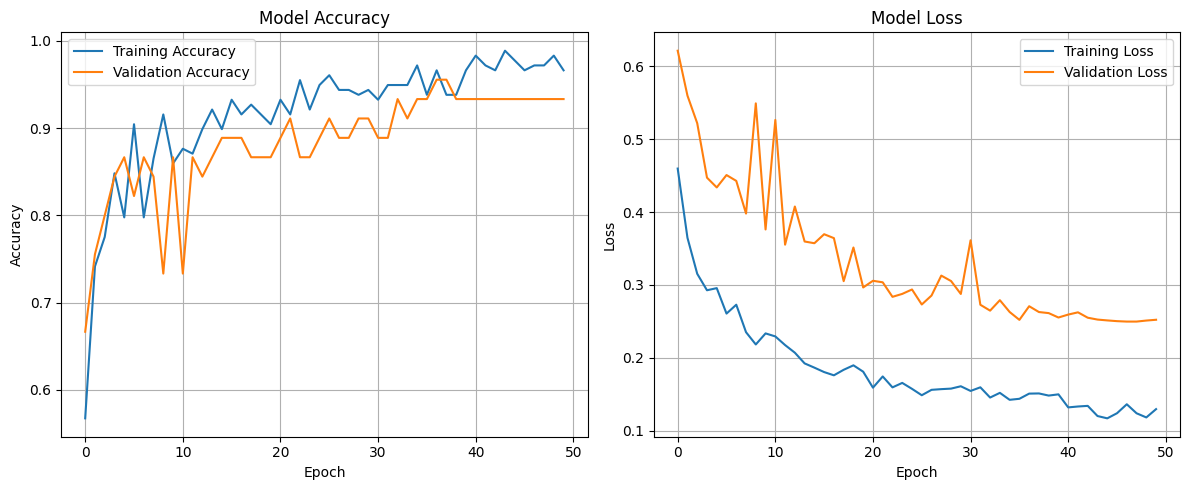

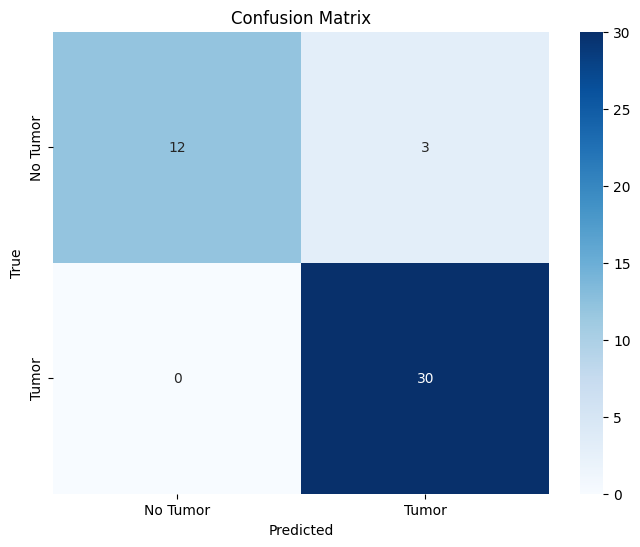

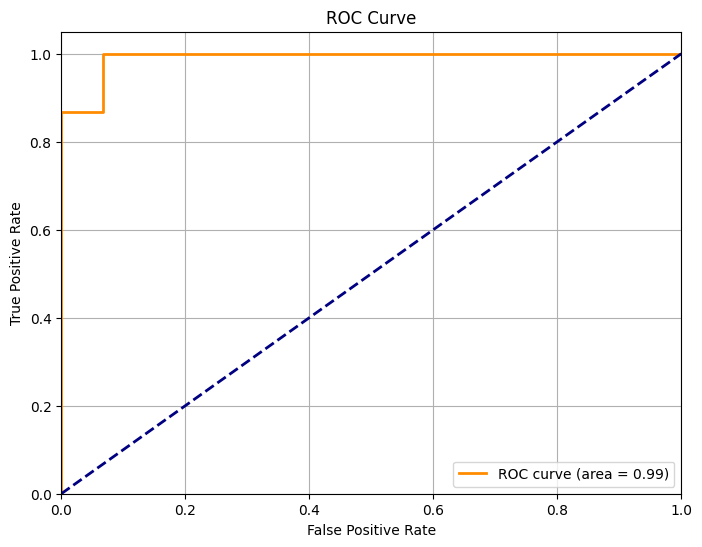

In [38]:
# Generate predictions for detailed analysis
test_generator.reset()
y_pred_probs = model.predict(test_generator, verbose=1)
y_true = test_generator.classes
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Display detailed classification metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['No Tumor', 'Tumor']))

# Visualize training history - accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Visualize training history - loss curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Visualize confusion matrix to see prediction errors
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'],yticklabels=['No Tumor', 'Tumor'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Create ROC curve to evaluate binary classifier performance
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()